# Dependencies

In [1]:
import os, warnings, shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from sklearn.model_selection import StratifiedKFold


SEED = 0
warnings.filterwarnings("ignore")

# Parameters

In [2]:
MAX_LEN = 192
tokenizer_path = 'jplu/tf-xlm-roberta-large'

# Load data

In [3]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
train2.toxic = train2.toxic.round().astype(int)

train_df = pd.concat([train1[['comment_text', 'toxic']],
                      train2[['comment_text', 'toxic']].query('toxic==1'),
                      train2[['comment_text', 'toxic']].query('toxic==0').sample(n=100000, random_state=SEED)
                    ]).reset_index()

print('Train samples %d' % len(train_df))
display(train_df.head())

Train samples 435775


,index,comment_text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


# Tokenizer

In [4]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

# Data generation sanity check

In [5]:
for idx in range(5):
    print('\nRow %d' % idx)
    max_seq_len = 22
    comment_text = train_df['comment_text'].loc[idx]
    
    enc = tokenizer.encode_plus(comment_text, return_token_type_ids=False, pad_to_max_length=True, max_length=max_seq_len)
    
    print('comment_text  : "%s"' % comment_text)
    print('input_ids     : "%s"' % enc['input_ids'])
    print('attention_mask: "%s"' % enc['attention_mask'])
    
    assert len(enc['input_ids']) == len(enc['attention_mask']) == max_seq_len


Row 0
comment_text  : "Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
input_ids     : "[0, 5443, 5868, 2320, 44084, 70, 27211, 7, 7228, 1379, 759, 38937, 11627, 151402, 94492, 2063, 11213, 3542, 39531, 3674, 32, 2]"
attention_mask: "[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"

Row 1
comment_text  : "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"
input_ids     : "[0, 391, 25, 11, 98251, 38, 1529, 14858, 90, 903, 76615, 134855, 87, 25, 39, 48903, 214, 538, 179933, 678, 5, 2]"
attention_mask: "[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"

Row 2
comment_text  : "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant i

# 5-Fold split

In [6]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for fold_n, (train_idx, val_idx) in enumerate(folds.split(train_df, train_df['toxic'])):
    print('Fold: %s, Train size: %s, Validation size %s' % (fold_n+1, len(train_idx), len(val_idx)))
    train_df[('fold_%s' % str(fold_n+1))] = 0
    train_df[('fold_%s' % str(fold_n+1))].loc[train_idx] = 'train'
    train_df[('fold_%s' % str(fold_n+1))].loc[val_idx] = 'validation'

Fold: 1, Train size: 348620, Validation size 87155
Fold: 2, Train size: 348620, Validation size 87155
Fold: 3, Train size: 348620, Validation size 87155
Fold: 4, Train size: 348620, Validation size 87155
Fold: 5, Train size: 348620, Validation size 87155


# Label distribution

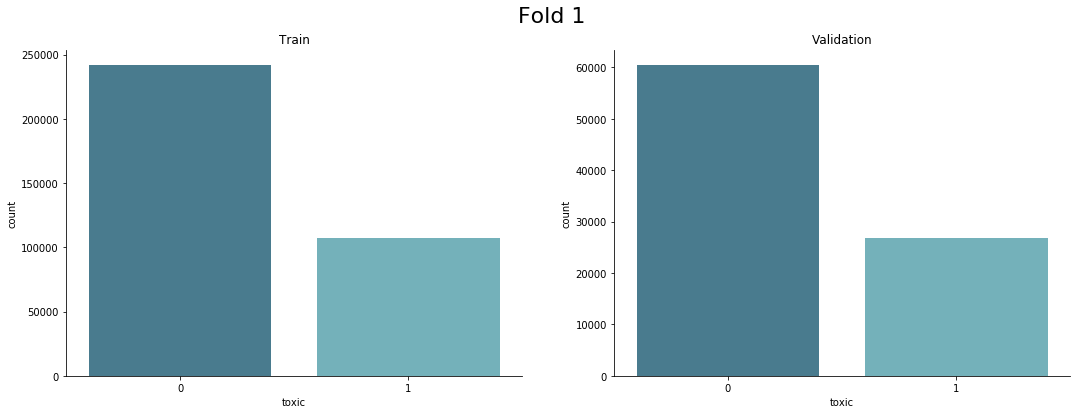

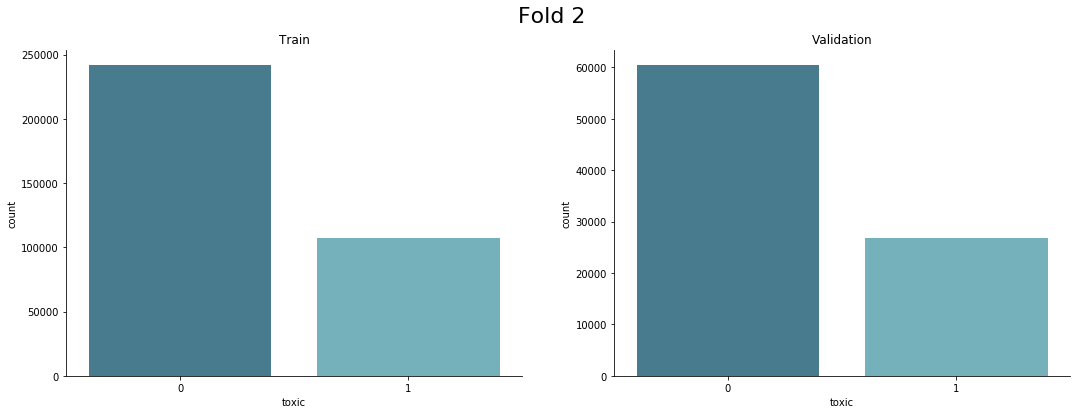

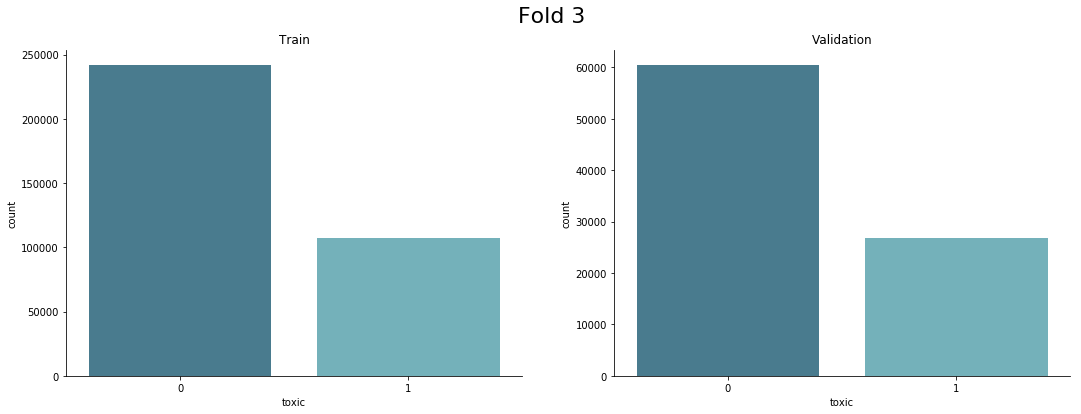

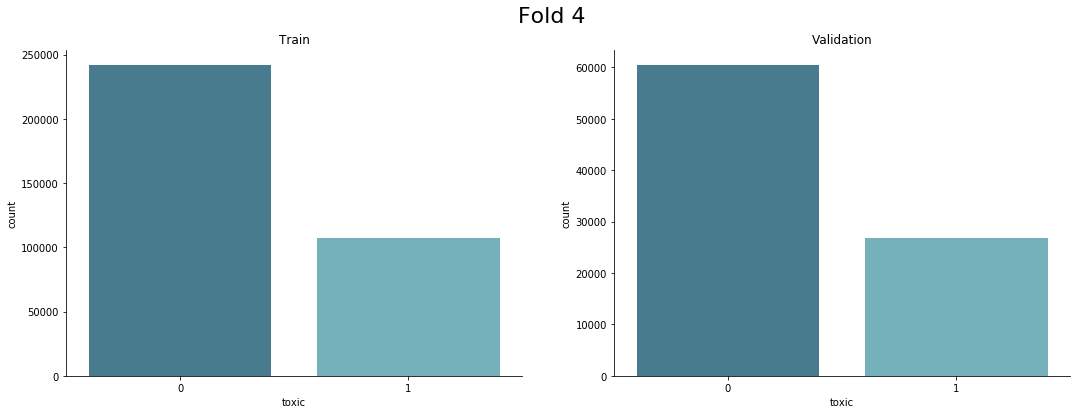

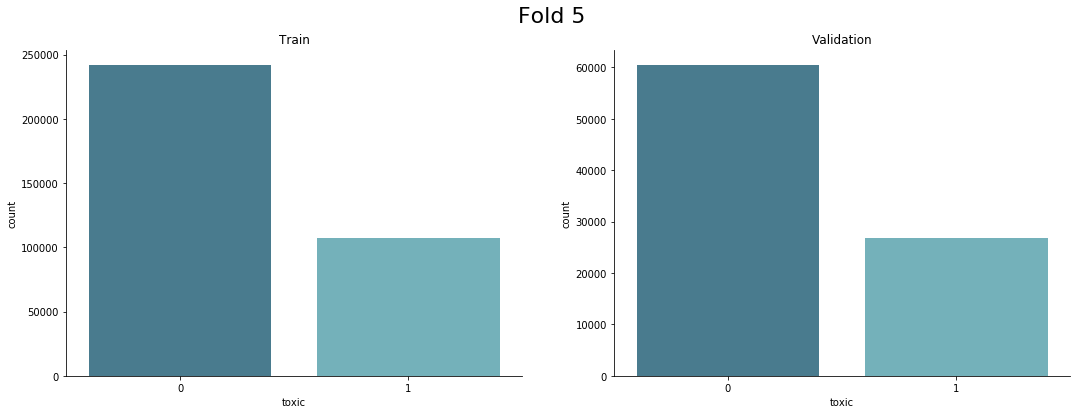

In [7]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)    
    sns.countplot(x="toxic", data=train_df[train_df[('fold_%s' % fold_n)] == 'train'], palette="GnBu_d", ax=ax1).set_title('Train')
    sns.countplot(x="toxic", data=train_df[train_df[('fold_%s' % fold_n)] == 'validation'], palette="GnBu_d", ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

# Output 5-fold set

In [8]:
train_df.to_csv('5-fold.csv', index=False)
display(train_df.head())

for fold_n in range(folds.n_splits):
    if fold_n < 3:
        fold_n += 1
        base_path = 'fold_%d/' % fold_n

        # Create dir
        os.makedirs(base_path)

        x_train = tokenizer.batch_encode_plus(train_df[train_df[('fold_%s' % fold_n)] == 'train']['comment_text'].values, 
                                                  return_token_type_ids=False, 
                                                  return_attention_masks=False, 
                                                  pad_to_max_length=True, 
                                                  max_length=MAX_LEN)

#         x_train = np.array([np.array(x_train['input_ids']), 
#                             np.array(x_train['attention_mask'])])
        x_train = np.array(np.array(x_train['input_ids']))

        x_valid = tokenizer.batch_encode_plus(train_df[train_df[('fold_%s' % fold_n)] == 'validation']['comment_text'].values, 
                                                  return_token_type_ids=False, 
                                                  return_attention_masks=False, 
                                                  pad_to_max_length=True, 
                                                  max_length=MAX_LEN)

#         x_valid = np.array([np.array(x_valid['input_ids']), 
#                             np.array(x_valid['attention_mask'])])
        x_valid = np.array(np.array(x_valid['input_ids']))

        y_train = train_df[train_df[('fold_%s' % fold_n)] == 'train']['toxic'].values
        y_valid = train_df[train_df[('fold_%s' % fold_n)] == 'validation']['toxic'].values

        np.save(base_path + 'x_train', np.asarray(x_train))
        np.save(base_path + 'y_train', y_train)
        np.save(base_path + 'x_valid', np.asarray(x_valid))
        np.save(base_path + 'y_valid', y_valid)

        print('\nFOLD: %d' % (fold_n))
        print('x_train shape:', x_train.shape)
        print('y_train shape:', y_train.shape)
        print('x_valid shape:', x_valid.shape)
        print('y_valid shape:', y_valid.shape)
    
#  Compress logs dir
!tar -cvzf fold_1.tar.gz fold_1
!tar -cvzf fold_2.tar.gz fold_2
!tar -cvzf fold_3.tar.gz fold_3
# !tar -cvzf fold_4.tar.gz fold_4
# !tar -cvzf fold_5.tar.gz fold_5

# Delete logs dir
shutil.rmtree('fold_1')
shutil.rmtree('fold_2')
shutil.rmtree('fold_3')
# shutil.rmtree('fold_4')
# shutil.rmtree('fold_5')

,index,comment_text,toxic,fold_1,fold_2,fold_3,fold_4,fold_5
0,0,Explanation\nWhy the edits made under my usern...,0,train,validation,train,train,train
1,1,D'aww! He matches this background colour I'm s...,0,train,validation,train,train,train
2,2,"Hey man, I'm really not trying to edit war. It...",0,train,train,train,train,validation
3,3,"""\nMore\nI can't make any real suggestions on ...",0,train,validation,train,train,train
4,4,"You, sir, are my hero. Any chance you remember...",0,train,train,train,train,validation



FOLD: 1
x_train shape: (348620, 192)
y_train shape: (348620,)
x_valid shape: (87155, 192)
y_valid shape: (87155,)

FOLD: 2
x_train shape: (348620, 192)
y_train shape: (348620,)
x_valid shape: (87155, 192)
y_valid shape: (87155,)

FOLD: 3
x_train shape: (348620, 192)
y_train shape: (348620,)
x_valid shape: (87155, 192)
y_valid shape: (87155,)
fold_1/
fold_1/y_train.npy
fold_1/x_valid.npy
fold_1/x_train.npy
fold_1/y_valid.npy
fold_2/
fold_2/y_train.npy
fold_2/x_valid.npy
fold_2/x_train.npy
fold_2/y_valid.npy
fold_3/
fold_3/y_train.npy
fold_3/x_valid.npy
fold_3/x_train.npy
fold_3/y_valid.npy


# Validation set

In [9]:
valid_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv", usecols=['comment_text', 'toxic', 'lang'])
display(valid_df.head())

x_valid = tokenizer.batch_encode_plus(valid_df['comment_text'].values, 
                                      return_token_type_ids=False, 
                                      return_attention_masks=False, 
                                      pad_to_max_length=True, 
                                      max_length=MAX_LEN)

# x_valid = np.array([np.array(x_valid['input_ids']), 
#                     np.array(x_valid['attention_mask'])])
x_valid = np.array(np.array(x_valid['input_ids']))

y_valid = valid_df['toxic'].values

np.save('x_valid', np.asarray(x_valid))
np.save('y_valid', y_valid)
print('x_valid shape:', x_valid.shape)
print('y_valid shape:', y_valid.shape)

,comment_text,lang,toxic
0,Este usuario ni siquiera llega al rango de ...,es,0
1,Il testo di questa voce pare esser scopiazzato...,it,0
2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


x_valid shape: (8000, 192)
y_valid shape: (8000,)


# Test set

In [10]:
test_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv", usecols=['content'])
display(test_df.head())

x_test = tokenizer.batch_encode_plus(test_df['content'].values, 
                                     return_token_type_ids=False, 
                                     return_attention_masks=False, 
                                     pad_to_max_length=True, 
                                     max_length=MAX_LEN)

# x_test = np.array([np.array(x_test['input_ids']), 
#                    np.array(x_test['attention_mask'])])
x_test = np.array(np.array(x_test['input_ids']))


np.save('x_test', np.asarray(x_test))
print('x_test shape:', x_test.shape)

,content
0,Doctor Who adlı viki başlığına 12. doctor olar...
1,"Вполне возможно, но я пока не вижу необходимо..."
2,"Quindi tu sei uno di quelli conservativi , ..."
3,Malesef gerçekleştirilmedi ancak şöyle bir şey...
4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...


x_test shape: (63812, 192)
